# Linear Discriminant Analysis

## References

https://www.kaggle.com/datasets/gpreda/iris-dataset?select=iris.csv

## Import Python Libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [83]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black
c6 = ["#fbfce6", "#a2daf2", "#ffc7c7"]
c7 = [(0, 0, 1), (0, 1 ,0), (1, 0, 0)]

## Import Dataset

In [84]:
# Source: https://www.kaggle.com/datasets/gpreda/iris-dataset?select=iris.csv

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: id
# X02: sepal_length
# X03: sepal_width
# X04: petal_length
# X05: petal_width
#   y: species

In [85]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/iris.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,id,sepal_length,sepal_width,petal_length,petal_width,species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [86]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'species'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [87]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.y = df1.y.astype('str')

df1.head()


,X1,X2,X3,X4,X5,y
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [88]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      150 non-null    int64  
 1   X2      150 non-null    float64
 2   X3      150 non-null    float64
 3   X4      150 non-null    float64
 4   X5      150 non-null    float64
 5   y       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [89]:
# describe data
df1.describe()

,X1,X2,X3,X4,X5
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [90]:
# check missing values
df1.isna().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
y     0
dtype: int64

## Data Cleaning and Transformation

In [91]:
# response column
y_col = new_y_col
y_col

'y'

In [92]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X1', 'X2', 'X3', 'X4', 'X5'], dtype='object')

In [93]:
# get unique y_labels
y_labels = np.sort(df1[y_col].unique())
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'setosa': 0, 'versicolor': 1, 'virginica': 2}

In [94]:
# rename y_labels
df1[y_col] = df1[y_col].replace(y_labels)
df1.head()

,X1,X2,X3,X4,X5,y
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [95]:
# # check label distribution
# temp_labels = list(y_labels.values())
# cond_list = []
# count_list = []
# for i in np.arange(len(temp_labels)):
#   # condition for rows matching response label
#   # print(i)
#   x = temp_labels[i]
#   temp_cond = list(df1[y_col] == x)
#   cond_list.append(temp_cond)
#   # print(cond_list)
#   # get total label count
#   temp_n = np.sum(cond_list[i])
#   # print(temp_n)
#   count_list.append(temp_n)
  
# # max label count
# n_max = np.max(count_list)
# # index where max value occurs
# i_max = np.where(count_list == n_max)[0][0]
# # index where max value does not occurs
# i_notmax = np.where(count_list != n_max)[0]

# print(temp_labels)
# print(count_list)
# print(n_max)
# print(i_max)
# print(i_notmax)

In [96]:
# # upsample minority labels
# df_upsample_list = []
# for i in i_notmax:
#   # print(i)
#   # get dataframe rows where label exsists
#   cond = cond_list[i]
#   # print(cond)
#   df_temp = df1.iloc[cond,:]
#   # print(df_temp.info())
  
#   # determine amount to upsample 
#   n_diff = n_max - count_list[i]
#   # print(n_diff)
  
#   # generate upsample dataframe 
#   df_upsample_temp = resample(
#     df_temp,
#     replace = True,
#     n_samples = n_diff,
#     random_state = random_state
#   )
#   df_upsample_list.append(df_upsample_temp)

# # put all dataframes in df_upsample_list into one
# df_upsample_list = pd.concat(df_upsample_list, ignore_index = True)

# # update df1 with upsampled dataframe
# df1 = pd.concat([df1, df_upsample_list], ignore_index = True)
# df1.info()

In [97]:
# # encode categorical values to numerical values
# le = LabelEncoder()

# categorical_cols = df1[X_cols].select_dtypes("object").columns
# # df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

# df1.head()

In [98]:
# update df1
X = df1[X_cols]
y = df1[y_col]
df1 = pd.concat([X, y], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      150 non-null    int64  
 1   X2      150 non-null    float64
 2   X3      150 non-null    float64
 3   X4      150 non-null    float64
 4   X5      150 non-null    float64
 5   y       150 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 7.2 KB


In [99]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X1,X2,X3,X4,X5,y
0,-1.720542,-0.900681,1.032057,-1.341272,-1.312977,0
1,-1.697448,-1.143017,-0.124958,-1.341272,-1.312977,0
2,-1.674353,-1.385353,0.337848,-1.398138,-1.312977,0
3,-1.651258,-1.506521,0.106445,-1.284407,-1.312977,0
4,-1.628164,-1.021849,1.263460,-1.341272,-1.312977,0


In [100]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

## Visualize Dataset

In [101]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (15, 15)

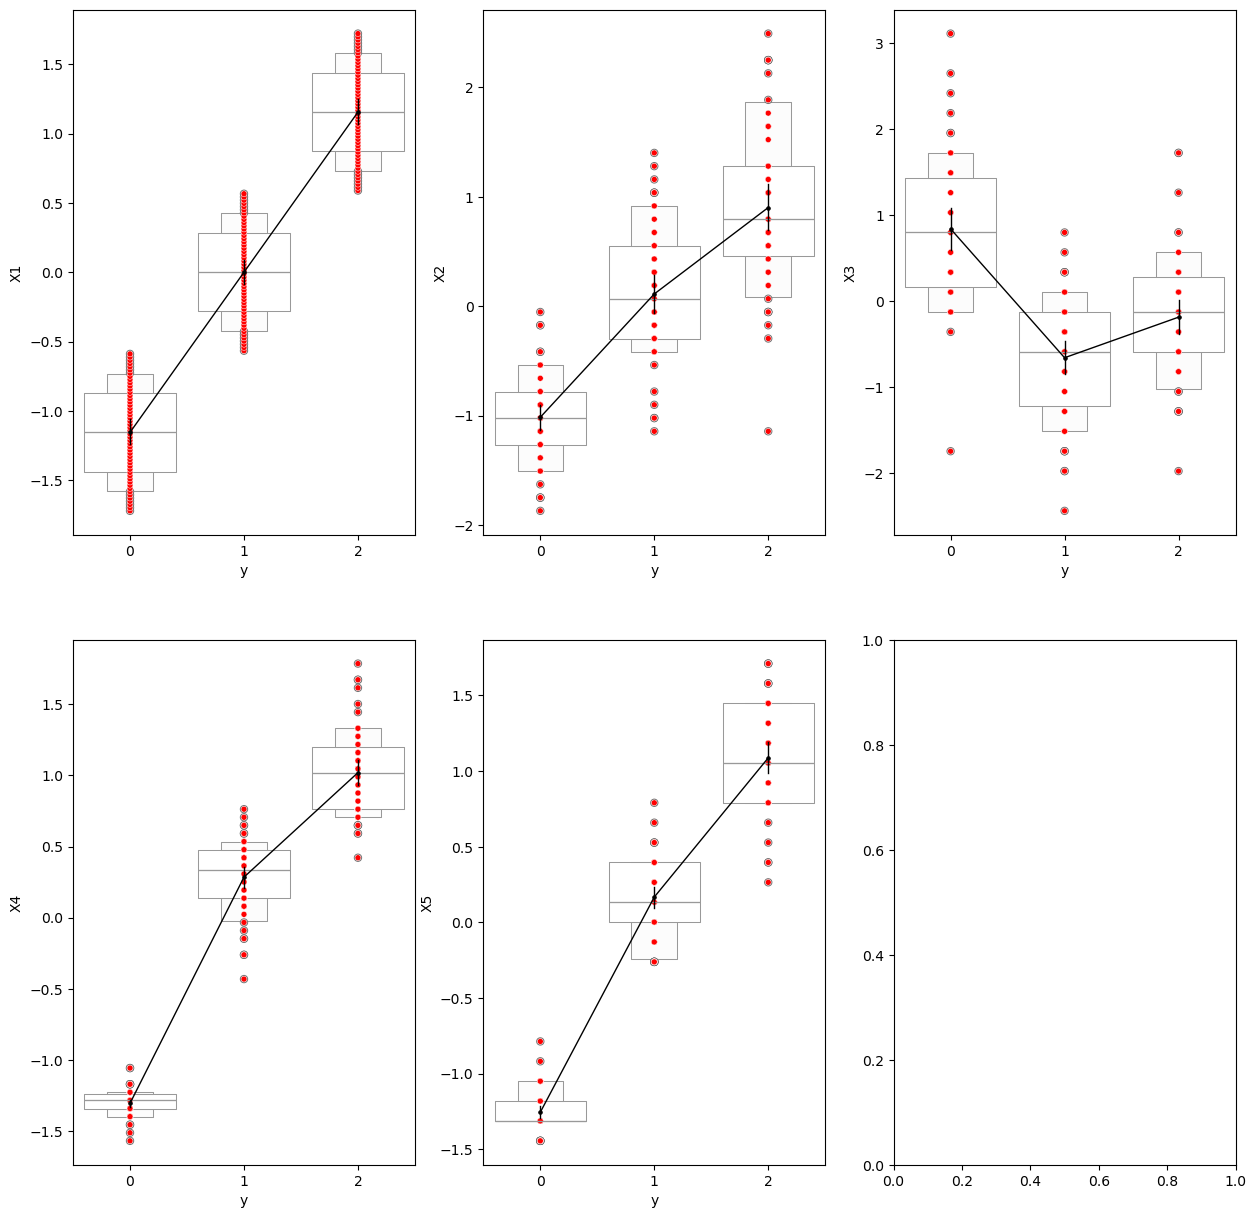

In [102]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.scatterplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Train and Test ML Model

In [103]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [104]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
  stratify = y, shuffle = True, 
  train_size = 0.8, random_state = random_state
)

In [105]:
# get linear discriminant analysis components
lda = LinearDiscriminantAnalysis(n_components = 2)

In [106]:
# fit linear discriminant analysis components to training data
temp = lda.fit(X_train, y_train)

In [107]:
# pca explained variance ration
var_ratio = lda.explained_variance_ratio_
var_ratio.sum()

0.9999999999999999

In [108]:
# transform data based on linear discriminant analysis components
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

In [109]:
# # initialize LogisticRegression model
# myfit = LogisticRegression(
#   fit_intercept = True,
#   tol = 1E-15,
#   random_state = random_state
# )

# initialize RandomForest model
myfit = RandomForestClassifier(
  random_state = random_state
)

In [110]:
# fit model
temp = myfit.fit(X_train, y_train)

In [111]:
# get predictions on test data
y_hat = myfit.predict(X_test)

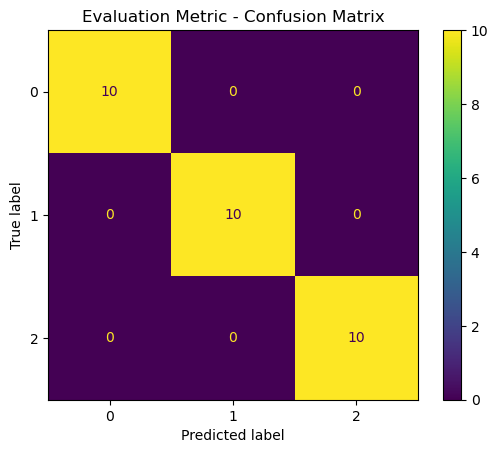

In [112]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [113]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [114]:
# function for plotting segments
def jra_plot_segments(X, y, classifier_fit, colors_contour, colors_scatter, title):
  X_values, y_values = X, y
  X1_min = X_values[:,0].min() - 1
  X2_min = X_values[:,1].min() - 1
  X2_max = X_values[:,1].max() + 1
  X1_max = X_values[:,0].max() + 1
  X1_values = np.arange(X1_min, X1_max, 0.01)
  X2_values = np.arange(X2_min, X2_max, 0.01)

  X1, X2 = np.meshgrid(X1_values, X2_values)

  X_fill = np.array([X1.ravel(), X2.ravel()]).T
  y_hat_fill = classifier_fit.predict(X_fill).reshape(X1.shape)
  y_hat_fill

  # plot labels
  for i, j in enumerate(np.unique(y_values)):
    plt.scatter(
      X_values[y_values == j, 0], 
      X_values[y_values == j, 1],
      color = colors_scatter[i],
      label = j
    )
  
  # plot segemented regions
  plt.contourf(X1, X2, y_hat_fill.astype('float'), 
    alpha = 0.5,
    cmap = ListedColormap(colors_contour)  # https://matplotlib.org/stable/users/explain/colors/colormaps.html
  )
  
  # clean up plot
  plt.xlim(X1_min, X1_max)
  plt.ylim(X2_min, X2_max)
  plt.title(title)
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  # plt.show()

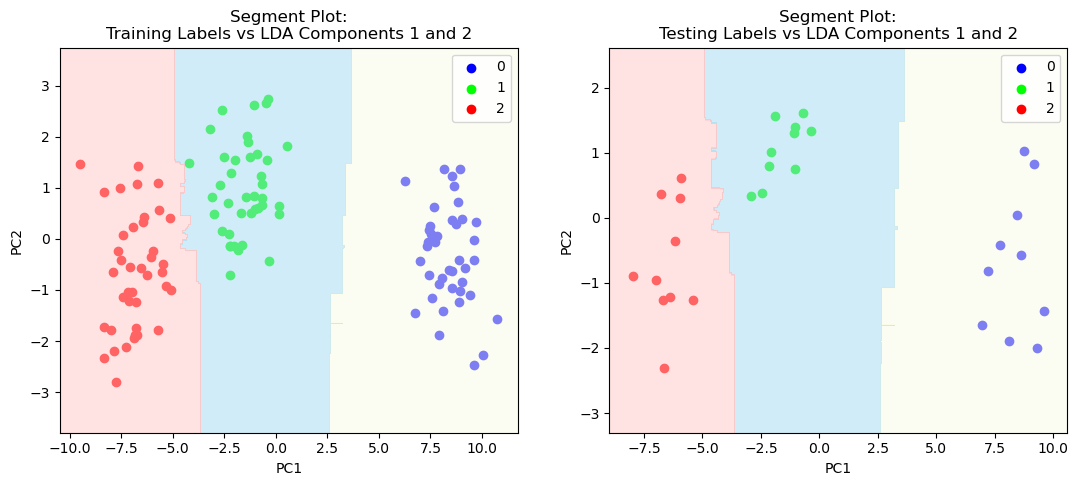

In [115]:
# plot segments for train + test dataset
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,5))
plt.subplot(121)
jra_plot_segments(
  X = X_train, y = y_train, 
  classifier_fit = myfit, 
  colors_contour = c6, colors_scatter = c7,
  title = 'Segment Plot:\nTraining Labels vs LDA Components 1 and 2'
)
plt.subplot(122)
jra_plot_segments(
  X = X_test, y = y_test, 
  classifier_fit = myfit, 
  colors_contour = c6, colors_scatter = c7,
  title = 'Segment Plot:\nTesting Labels vs LDA Components 1 and 2'
)

plt.show()